<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

## ColabFold v1.5.5：使用 MMseqs2 的 AlphaFold2

ColabFold 提供了一个简单易用的蛋白质结构预测与蛋白复合物结构预测工具，基于
[AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2)
和
[AlphaFold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1)。
序列比对（MSA）与模板（templates）通过
[MMseqs2](mmseqs.com)
和
[HHsearch](https://github.com/soedinglab/hh-suite)
自动生成。

如需了解更多细节，请查看本 notebook 底部的 <a href="#Instructions">使用说明（Instructions）</a>，
以及 [ColabFold GitHub](https://github.com/sokrypton/ColabFold) 和相关的
[Nature Protocols 教程文章](https://www.nature.com/articles/s41596-024-01060-5)。

旧版本链接：
[v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb),
[v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb),
[v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb),
[v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

参考文献：
[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M.
ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [1]:
#@title 输入蛋白质序列，然后点击 `运行时(Runtime)` -> `全部运行(Run all)`
#@markdown ##（建议先读这一段再改参数）
#@markdown **这一步在做什么？**
#@markdown - 你在这里输入蛋白质序列（单体或复合物），并设置任务名、是否做结构松弛（Amber relax）、是否使用模板（Templates）。
#@markdown - 程序会自动创建一个结果文件夹，并把输入写入一个 `CSV` 文件，后续预测步骤会读取它。
#@markdown
#@markdown **单体 vs 复合物怎么写？**
#@markdown - **单体（monomer）**：直接输入一条氨基酸序列，例如 `MKT...`
#@markdown - **复合物（complex / multimer）**：用冒号 `:` 分隔不同链，例如 `SEQ_A:SEQ_B`（二聚体）或 `A:B:C`（三聚体）
#@markdown
#@markdown **课堂建议怎么选？**
#@markdown - 只想快速演示：`num_relax=0`，`template_mode="none"`（安装更快，运行更稳）
#@markdown - 想展示“更物理合理”的结构：把 `num_relax` 设为 `1` 或 `5`（会更慢）
#@markdown - 想展示模板辅助：把 `template_mode` 设为 `"pdb100"`（或上传自定义模板）
#@markdown
#@markdown **结果会保存在哪里？**
#@markdown - 会生成一个名为 `jobname_hash` 的文件夹（例如 `test_ab123`），避免不同同学/不同实验互相覆盖。

from google.colab import files
import os
import re
import hashlib
import random
from sys import version_info

python_version = f"{version_info.major}.{version_info.minor}"

# -----------------------------
# 工具函数：给任务名加一个短哈希，避免重名覆盖
# -----------------------------
def add_hash(name, seq):
  """在任务名后追加短哈希，确保不同输入不会覆盖同名目录。"""
  return name + "_" + hashlib.sha1(seq.encode()).hexdigest()[:5]

# -----------------------------
# 1) 输入序列（课堂：先讲清楚“单体/复合物写法”）
# -----------------------------
query_sequence = 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL' #@param {type:"string"}
#@markdown - 蛋白序列
#@markdown - 使用 `:` 分隔不同蛋白链（用于**复合物建模**，支持同源/异源寡聚体）
#@markdown - 例：同源二聚体：`PI...SK:PI...SK`；异源二聚体：`SEQ_A:SEQ_B`
#@markdown - **注意：**序列中不要出现空格/换行（程序会自动去除空白，但尽量输入干净）

# -----------------------------
# 2) 任务名（用来命名结果文件夹）
# -----------------------------
jobname = 'Lysozyme' #@param {type:"string"}
#@markdown - 任务名
#@markdown - 建议用“学生姓名缩写_实验编号”之类的格式，例如 `dylan_lab1`，便于管理结果

# -----------------------------
# 3) 结构松弛（Amber relax）
# -----------------------------
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - 松弛数量
#@markdown - `0`：不做松弛（最快，课堂演示推荐）
#@markdown - `1`：只对排名第 1 的结构做松弛（稍慢）
#@markdown - `5`：对排名前 5 的结构都做松弛（最慢，但更全面）
#@markdown **教学提示：**松弛（relax）主要用于缓解不合理的原子碰撞/几何结构问题，不一定总是“更正确”，但通常更“物理合理”。

# -----------------------------
# 4) 模板模式（Templates）
# -----------------------------
template_mode = "none" #@param ["none", "pdb100", "custom"]
#@markdown - 模版模式
#@markdown - `none`：不使用模板信息（课堂推荐默认）
#@markdown - `pdb100`：在 PDB100 中自动检测模板（见 [说明](#pdb100)）
#@markdown - `custom`：上传你自己的模板（PDB 或 mmCIF，见 [说明](#custom_templates)）
#@markdown **教学提示：**
#@markdown - 模板能帮助某些蛋白更稳定，但也可能引入偏置；做对比实验时可分别跑 `none` vs `pdb100`。

# 根据松弛数量判断是否启用 Amber（注意：这里变量名必须保持英文 use_amber 的语义，后面 cell 会用）
use_amber = num_relax > 0

# -----------------------------
# 5) 清洗输入（去空白、清理任务名非法字符）
# -----------------------------
query_sequence = "".join(query_sequence.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)

# 生成带哈希的任务名（避免重复）
jobname = add_hash(basejobname, query_sequence)

# -----------------------------
# 6) 防止目录冲突：若已存在就自动追加 _0, _1 ...
# -----------------------------
def check(folder):
  """目录不存在则返回 True（可用），存在则返回 False。"""
  return not os.path.exists(folder)

if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"):
    n += 1
  jobname = f"{jobname}_{n}"

# -----------------------------
# 7) 创建结果目录并保存输入 CSV（后续预测读取 queries_path）
# -----------------------------
os.makedirs(jobname, exist_ok=True)

queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  # 这里保留 id,sequence 的格式是为了与 ColabFold 后续函数兼容
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# -----------------------------
# 8) 处理模板模式（保持变量名 use_templates/custom_template_path 与后续 cell 一致）
# -----------------------------
if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None

elif template_mode == "custom":
  custom_template_path = os.path.join(jobname, "template")
  os.makedirs(custom_template_path, exist_ok=True)

  # 上传模板文件（可多选）
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, os.path.join(custom_template_path, fn))

else:
  custom_template_path = None
  use_templates = False

# -----------------------------
# 9) 程序识别到什么
# -----------------------------
print(" 任务名称（jobname）：", jobname)
print(" 输入序列（sequence）：", query_sequence)
print(" 序列长度（去掉链分隔符:）：", len(query_sequence.replace(":", "")))

# 自动判断你输入的是单体还是复合物（仅提示，不影响后续）
if ":" in query_sequence:
  print(" 检测到 ':'：这是复合物/多链输入（complex / multimer）。")
else:
  print(" 未检测到 ':'：这是单体输入（monomer）。")

print(" 当前选项：松弛数量 =", num_relax, " | 模板模式 =", template_mode)


 任务名称（jobname）： Lysozyme_ce6c6
 输入序列（sequence）： KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL
 序列长度（去掉链分隔符:）： 129
 未检测到 ':'：这是单体输入（monomer）。
 当前选项：松弛数量 = 0  | 模板模式 = none


In [2]:
#@title 安装依赖（Install dependencies）
#@markdown **这一步在做什么？**
#@markdown - 安装 ColabFold/AlphaFold 相关 Python 包与模型运行所需依赖。
#@markdown - 根据你是否启用 **Amber relax（结构松弛）** 或 **Templates（模板搜索）**，额外安装 Conda/Mamba 以及 HHsuite / OpenMM 等工具。
#@markdown
#@markdown **为什么要用这些“READY 文件”？（COLABFOLD_READY / CONDA_READY / HH_READY / AMBER_READY）**
#@markdown - 它们是“安装完成标记”，避免你每次重新运行都重复安装（节省时间、减少出错概率）。
#@markdown - **课堂提醒：不要改这些文件名**，否则会导致重复安装或逻辑判断失效。
#@markdown
#@markdown **课堂建议：**
#@markdown - 只是演示预测流程：可以先把 `num_relax=0`（不做 Amber relax）并且 `template_mode="none"`，安装更快。
#@markdown - 要展示更“物理合理”的结构：把 `num_relax>0` 开启 Amber relax（会更慢）。
#@markdown - 要讲模板辅助预测：把 `template_mode="pdb100"` 或 `"custom"` 打开（会安装 HHsuite）。
#@markdown
#@markdown **常见问题（如果卡住/报错）：**
#@markdown - 重新运行本单元格通常可恢复；必要时使用 “运行时 → 恢复出厂设置(Factory reset runtime)” 后再跑。
#@markdown - 安装过程依赖网络，偶尔会因 Colab 服务器或网络波动失败。
%%time

import os

USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

# -----------------------------
# 1) 安装 ColabFold 主依赖
# -----------------------------
if not os.path.isfile("COLABFOLD_READY"):
  print("正在安装 ColabFold（核心依赖）...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")

  # TPU 场景下的兼容处理
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")

  # 建立软链接（便于后续 import/路径查找；保持与原 notebook 一致）
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")

  # Hack：修复 TF 某些情况下的崩溃（属于兼容性补丁，建议不要改）
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")

  # 写入完成标记：下次就不会重复安装
  os.system("touch COLABFOLD_READY")
  print("ColabFold 安装完成。")
else:
  print("检测到 COLABFOLD_READY：已安装 ColabFold，跳过重复安装。")

# -----------------------------
# 2) 如需 Amber 或 Templates，则安装 Conda/Mamba（便于装 HHsuite/OpenMM 等）
# -----------------------------
if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("正在安装 Conda（Miniforge / Mamba，用于安装 OpenMM / HHsuite 等）...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")
    print(" Conda/Mamba 安装完成。")
  else:
    print(" 检测到 CONDA_READY：已安装 Conda/Mamba，跳过重复安装。")
else:
  # 提示：不开 Amber/模板时这一步会跳过，安装更快
  print(" 未启用 Amber relax 或 Templates：跳过 Conda/Mamba 安装。")

# -----------------------------
# 3) 根据需要安装 HHsuite（模板搜索）与 Amber/OpenMM（结构松弛）
# -----------------------------
# 注意：下面的条件逻辑尽量不要改动（它决定“装哪些组件”以及避免重复安装）
if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("正在安装 HHsuite + Amber/OpenMM（同时需要模板与结构松弛）...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
  print(" HHsuite 与 Amber/OpenMM 安装完成。")

else:
  if USE_TEMPLATES:
    if not os.path.isfile("HH_READY"):
      print("正在安装 HHsuite（用于模板搜索 / HHsearch）...")
      os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
      os.system("touch HH_READY")
      print("HHsuite 安装完成。")
    else:
      print("检测到 HH_READY：已安装 HHsuite，跳过重复安装。")

  if USE_AMBER:
    if not os.path.isfile("AMBER_READY"):
      print("正在安装 Amber/OpenMM（用于结构松弛 relax）...")
      os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
      os.system("touch AMBER_READY")
      print("Amber/OpenMM 安装完成。")
    else:
      print("检测到 AMBER_READY：已安装 Amber/OpenMM，跳过重复安装。")

  if (not USE_TEMPLATES) and (not USE_AMBER):
    print("未启用 Templates 或 Amber：本步骤无需安装 HHsuite/OpenMM。")

# -----------------------------
# 当前启用了哪些功能
# -----------------------------
print("\n 当前配置总结：")
print(f"- USE_TEMPLATES = {USE_TEMPLATES}（模板搜索）")
print(f"- USE_AMBER     = {USE_AMBER}（结构松弛 relax）")
print(f"- Python        = {PYTHON_VERSION}")

正在安装 ColabFold（核心依赖）...
ColabFold 安装完成。
 未启用 Amber relax 或 Templates：跳过 Conda/Mamba 安装。
未启用 Templates 或 Amber：本步骤无需安装 HHsuite/OpenMM。

 当前配置总结：
- USE_TEMPLATES = False（模板搜索）
- USE_AMBER     = False（结构松弛 relax）
- Python        = 3.12
CPU times: user 700 µs, sys: 2.66 ms, total: 3.36 ms
Wall time: 37.4 s


In [3]:
#@markdown ### MSA 选项（自定义 MSA 上传 / 单序列 / 链配对模式）
#@markdown **这一步在做什么？**
#@markdown - MSA（Multiple Sequence Alignment，多序列比对）是 AlphaFold/ColabFold 预测的重要信息来源：一般来说，MSA 越丰富（覆盖越好、深度越大），预测越稳定、越可信。
#@markdown - 复合物（多链）时除了每条链自己的 MSA，还可能需要“配对 MSA”，用于推断链与链之间的共进化信号（有助于界面预测）。
#@markdown
#@markdown **课堂建议怎么选？**
#@markdown - **新手/演示（最推荐）**：`msa_mode="mmseqs2_uniref_env"` + `pair_mode="unpaired_paired"`
#@markdown - **只想跑得快**：`msa_mode="mmseqs2_uniref"`（少搜环境序列，通常更快但信息可能更少）
#@markdown - **没有 MSA 也要跑（对比实验/极快）**：`msa_mode="single_sequence"`（通常置信度更低）
#@markdown - **你已经有自己的 A3M**：`msa_mode="custom"`（例如用 HHblits/本地数据库生成的 MSA）
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]

#@markdown **链配对模式（pair_mode）主要用于复合物：**
#@markdown - `"unpaired_paired"`：同时使用 **配对 MSA + 未配对 MSA**（常用默认，信息最全面，通常最稳）
#@markdown - `"unpaired"`：每条链分别做各自的 MSA（不做配对；对界面信息可能较弱，但更“保守”）
#@markdown - `"paired"`：只使用配对序列（更严格；若可配对数据不足，可能效果反而变差）
#@markdown
#@markdown **课堂提示：**
#@markdown - 复合物预测里，`unpaired_paired` 往往是最不容易翻车的选择。
#@markdown - 若你的复合物来自不同物种/不同来源，配对很难成立时，可尝试 `unpaired`。
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}

#
# **下面这段代码在做什么？**
#- 根据你选择的 `msa_mode` 决定最终要用哪个 `.a3m` 文件作为输入；
#- 如果是 `custom`，则会弹出上传框让你上传 A3M，并从 A3M 的第一条序列更新 `query_sequence`（要求第一条序列是无 gap 的 query）。
# - 如果是 `single_sequence`，则会写一个只包含 query 的“伪 A3M”（没有真正的 MSA）。

# 决定使用哪个 a3m 文件（A3M 是一种常见的 MSA 文件格式）
if "mmseqs2" in msa_mode:
  # 使用 MMseqs2 在线搜索生成的 MSA（默认会生成 jobname.a3m）
  a3m_file = os.path.join(jobname, f"{jobname}.a3m")

elif msa_mode == "custom":
  # 使用用户上传的自定义 MSA（会重命名成 jobname.custom.a3m）
  a3m_file = os.path.join(jobname, f"{jobname}.custom.a3m")

  # 如果还不存在，就上传并处理一次（避免重复上传）
  if not os.path.isfile(a3m_file):
    # 上传自定义 MSA（A3M 文件）
    # 教学提示：A3M 的第一条 FASTA 记录必须是 query 序列且不含 gap（-）
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]

    # 读取并（必要时）从自定义 MSA 中更新 query_sequence
    # 逻辑：遇到第一个 header（>）后，第一条序列行就是 query_sequence
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa, inplace=1):
      if line.startswith(">"):
        header = header + 1
      if not line.rstrip():
        continue
      if (not line.startswith(">")) and header == 1:
        query_sequence = line.rstrip()
      print(line, end='')

    # 移动到本任务目录并改名
    os.rename(custom_msa, a3m_file)

    # 注意：这里把 queries_path 指向 a3m_file（后续会从它读取输入）
    queries_path = a3m_file
    print(f" 已移动自定义 MSA：{custom_msa} → {a3m_file}")

else:
  # 单序列模式：只写入 query_sequence（不做真正 MSA）
  # 教学提示：这种模式一般会更不稳定/置信度更低，主要用于“极快跑通流程”或“做对比实验”
  a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)
  print(f" 单序列模式：已生成 {a3m_file}（仅包含 query，不含真实 MSA）")

In [4]:
#@markdown ### 高级设置（Advanced settings / 进阶参数）
#@markdown 这部分用于控制 **模型类型（单体/复合物）**、**回收次数（recycles）**、**链配对策略（pairing）**、**Amber relax**、以及 **构象采样（dropout / seeds / max_msa）**。
#@markdown **课堂建议：**如果你只是教学演示或第一次跑，建议先保持默认（`model_type=auto`, `num_recycles=auto/3`, `max_msa=auto`, `num_seeds=1`, `use_dropout=False`），确保能稳定出结果后再逐项调整。

model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown **模型类型选择：**
#@markdown - `auto`（推荐默认）：自动判断输入是单体还是复合物。
#@markdown   - 单体（没有 `:` 分链）→ 使用 `alphafold2_ptm`
#@markdown   - 复合物（用 `:` 分链）→ 使用 `alphafold2_multimer_v3`
#@markdown - `alphafold2_ptm`：适合单体预测，输出包含 pTM 等指标。
#@markdown - `alphafold2_multimer_v3`（复合物推荐）：目前多链/复合物预测最常用的 multimer 版本。
#@markdown - `alphafold2_multimer_v1/v2`：旧版 multimer，通常不建议新项目再选，除非你要做版本对比复现实验。
#@markdown - `alphafold2`：较基础的单体模型（不含 ptm 相关配置），一般不优先。
#@markdown - `deepfold_v1`：另一套模型选项（按 notebook 的实现支持），课堂上一般不需要。
#@markdown **教学提示：**学生只要记住：单体→ptm；复合物→multimer_v3；不确定就用 auto。

num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown **Recycles（回收/迭代）次数：**
#@markdown - Recycle 越多，模型会反复“自我修正”结构，**可能提升结构质量**，但计算时间也会明显增加。
#@markdown - `auto`：自动设置
#@markdown   - 若 `model_type=alphafold2_multimer_v3` → `num_recycles=20`
#@markdown   - 否则 → `num_recycles=3`
#@markdown **建议：**
#@markdown - 教学演示：`3` 或 `auto`
#@markdown - 复合物更难：可以考虑 `6`、`12`，但会更慢
#@markdown - `0`：极快但质量可能差，通常不推荐
#@markdown - `24/48`：很慢，除非你明确追求更高精度或做严格对比实验

recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown **提前停止阈值（Early stop tolerance）：**
#@markdown - 作用：当连续 recycle 的改进很小，就提前停止，节省时间。
#@markdown - `auto`：自动设置
#@markdown   - 若 `model_type=alphafold2_multimer_v3` → `tol=0.5`
#@markdown   - 否则 → `tol=0.0`
#@markdown **怎么选：**
#@markdown - 单体：一般 `0.0`（更严格，不容易提前停）
#@markdown - 复合物：`0.5` 比较常见（更节省时间）
#@markdown - `1.0`：更容易提前停（更快，但可能略降质量）

relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown **Amber relax 最大迭代次数：**
#@markdown - relax 是对预测结构做物理能量最小化（常见于去除不合理键角/碰撞）。
#@markdown - `200`：较常用的折中（速度与效果平衡）
#@markdown - `2000`：更充分的 relax，但明显更慢
#@markdown - `0`：不限制（AlphaFold2 默认行为），可能非常耗时（课堂演示不建议）
#@markdown **注意：**要启用 relax，通常需要你在前面选择 `num_relax > 0`（并完成 openmm/pdbfixer 安装）。

pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown **链配对策略（用于复合物 paired MSA 的配对方式）：**
#@markdown - `greedy`（推荐默认）：只要在分类学上能匹配就尽量配对（更“宽松”，可获得更多可用配对信息）。
#@markdown - `complete`：要求所有序列必须在同一行完整匹配（更“严格”，配对更干净，但可能导致可用数据变少）。
#@markdown **建议：**
#@markdown - 大多数情况下用 `greedy`
#@markdown - 当你明确要高严格性配对（例如同一物种同一基因组的严格配对）才用 `complete`

calc_extra_ptm = False #@param {type:"boolean"}
#@markdown **额外评分输出：**
#@markdown - 开启后会返回链-链（pairwise）的 iptm / actifptm 等额外指标。
#@markdown **建议：**
#@markdown - 教学/快速跑：关闭（更简洁）
#@markdown - 做复合物界面分析/对比实验：可以开启（更全面）

#@markdown ---
#@markdown #### 构象采样（Sample settings / 采样设置）
#@markdown 这部分用于生成“多样化预测结果”（探索不确定性与构象变化），常用于：
#@markdown - 蛋白有多个构象状态（开放/闭合）
#@markdown - 柔性环区、可动结构域
#@markdown - 需要多组候选结构做后续筛选（例如聚类、PCA）
#@markdown **核心思想：**启用 dropout + 增加 seeds + 降低 max_msa → 通常能得到更丰富的结构多样性（但可能牺牲平均准确度）。

max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
#@markdown **MSA 深度上限（max_msa）：**
#@markdown - 值形如 `32:64` 表示限制 MSA 的深度（具体含义由实现决定，通常是“最大 cluster / extra MSA”之类的两段上限）。
#@markdown - MSA 越深：通常更稳定、更准确（但更“收敛”，多样性变小）
#@markdown - MSA 越浅：不确定性更大，可能出现更多不同构象（适合采样）
#@markdown **建议：**
#@markdown - 普通预测（追求准确）：`auto` 或更大如 `256:512` / `512:1024`
#@markdown - 构象采样：`32:64` 或 `16:32`（更容易出现多样性）

num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
#@markdown **随机种子数量（num_seeds）：**
#@markdown - 每个 seed 通常会产生一组独立预测（可理解为“多跑几次”）。
#@markdown - seeds 越多：候选结构越多，但时间/资源线性增加。
#@markdown **建议：**
#@markdown - 教学演示：`1` 或 `2`
#@markdown - 构象采样/做统计：`8` 或 `16`

use_dropout = False #@param {type:"boolean"}
#@markdown **是否启用 Dropout：**
#@markdown - Dropout 会在推理时引入随机性，帮助“从不确定性中采样”。
#@markdown **建议：**
#@markdown - 普通预测：关闭（更稳定）
#@markdown - 构象采样：开启（通常与 `num_seeds>=8`、`max_msa` 变小配合）

# 将表单字符串转换为运行所需类型（不要随意改动）
num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto":
  max_msa = None

#@markdown ---
#@markdown #### 保存设置（Save settings / 输出保存）
#@markdown 这部分控制中间文件与结果的保存策略。课堂演示建议只保留必要结果，避免占用过多空间。

save_all = False #@param {type:"boolean"}
#@markdown - 保存更多中间文件（更完整，但占空间更大；适合做严谨复现实验或debug）

save_recycles = False #@param {type:"boolean"}
#@markdown - 保存每次 recycle 的中间结构（用于分析“迭代如何改进结构”，但文件会很多）

save_to_google_drive = False #@param {type:"boolean"}
#@markdown - 若开启，会将最终结果压缩包（zip）上传到你的 Google Drive（适合长时间保存或分享给学生）

dpi = 200 #@param {type:"integer"}
#@markdown - 设置导出图片分辨率（dpi）。课堂投屏/打印可设更高；默认 200 通常够用。

# Google Drive 登录与授权（不要改动导入与授权流程）
if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("你已登录 Google Drive，可以开始上传结果了！")

#@markdown ---
#@markdown  **重要提醒：**修改完表单参数后，别忘了点击 `运行时(Runtime)` -> `全部运行(Run all)` 才会应用最新设置。

2026-01-27 16:07:04 INFO Running on GPU
2026-01-27 16:07:05 INFO Found 5 citations for tools or databases
2026-01-27 16:07:05 INFO Query 1/1: Lysozyme_ce6c6 (length 129)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


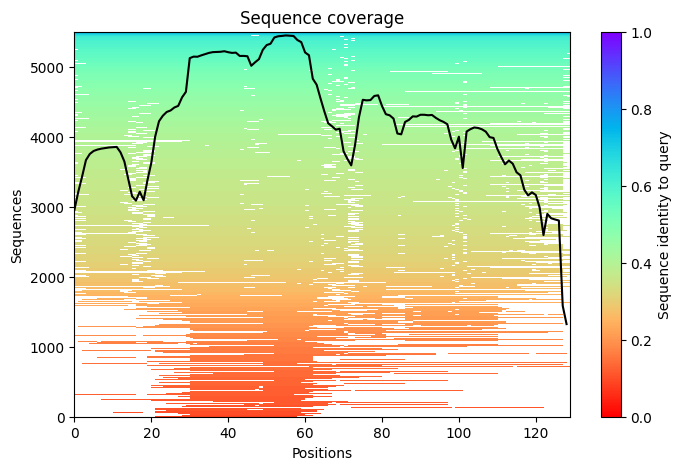

2026-01-27 16:07:07 INFO Setting max_seq=512, max_extra_seq=4996
2026-01-27 16:08:22 INFO alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.8 pTM=0.882
2026-01-27 16:09:02 INFO alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=97.2 pTM=0.89 tol=0.136
2026-01-27 16:09:03 INFO alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=97.4 pTM=0.893 tol=0.059
2026-01-27 16:09:05 INFO alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=97.4 pTM=0.894 tol=0.0349
2026-01-27 16:09:05 INFO alphafold2_ptm_model_1_seed_000 took 103.1s (3 recycles)


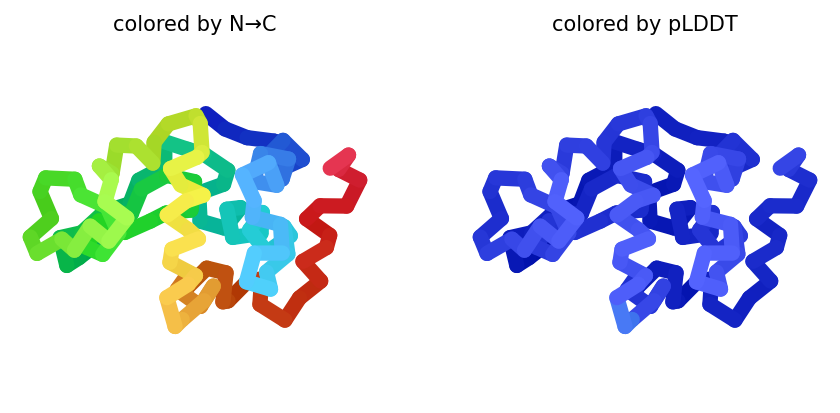

2026-01-27 16:09:06 INFO alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=96.6 pTM=0.887
2026-01-27 16:09:08 INFO alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=97.3 pTM=0.897 tol=0.136
2026-01-27 16:09:09 INFO alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=97.5 pTM=0.9 tol=0.0522
2026-01-27 16:09:11 INFO alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=97.6 pTM=0.9 tol=0.0282
2026-01-27 16:09:11 INFO alphafold2_ptm_model_2_seed_000 took 6.1s (3 recycles)


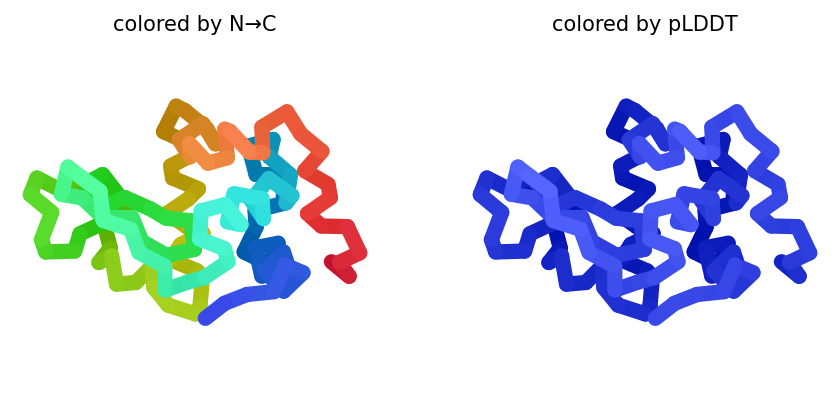

2026-01-27 16:09:13 INFO alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.893
2026-01-27 16:09:14 INFO alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.7 pTM=0.9 tol=0.126
2026-01-27 16:09:16 INFO alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.8 pTM=0.902 tol=0.0599
2026-01-27 16:09:17 INFO alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.8 pTM=0.9 tol=0.0283
2026-01-27 16:09:17 INFO alphafold2_ptm_model_3_seed_000 took 6.1s (3 recycles)


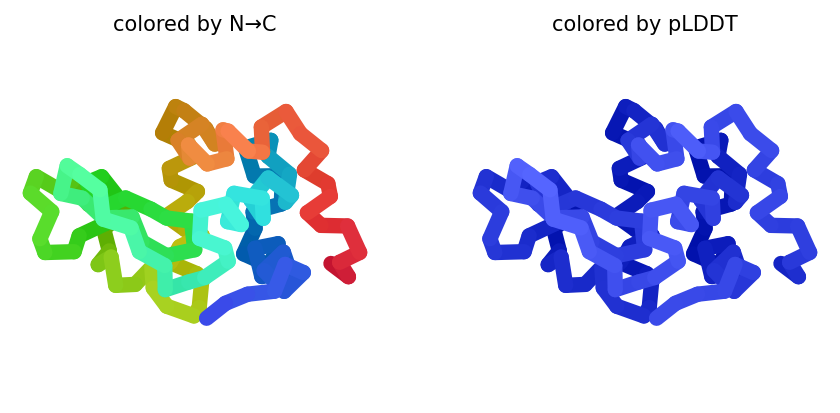

2026-01-27 16:09:19 INFO alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.2 pTM=0.895
2026-01-27 16:09:20 INFO alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.8 pTM=0.903 tol=0.181
2026-01-27 16:09:22 INFO alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=97.8 pTM=0.904 tol=0.0419
2026-01-27 16:09:23 INFO alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=97.8 pTM=0.902 tol=0.0238
2026-01-27 16:09:23 INFO alphafold2_ptm_model_4_seed_000 took 6.1s (3 recycles)


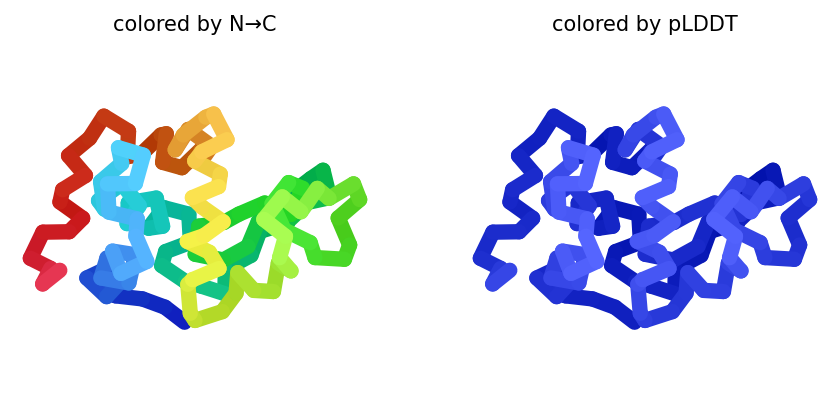

2026-01-27 16:09:25 INFO alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.6 pTM=0.902
2026-01-27 16:09:27 INFO alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=98 pTM=0.908 tol=0.131
2026-01-27 16:09:28 INFO alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=98.1 pTM=0.911 tol=0.0537
2026-01-27 16:09:30 INFO alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=98.1 pTM=0.91 tol=0.0309
2026-01-27 16:09:30 INFO alphafold2_ptm_model_5_seed_000 took 6.1s (3 recycles)


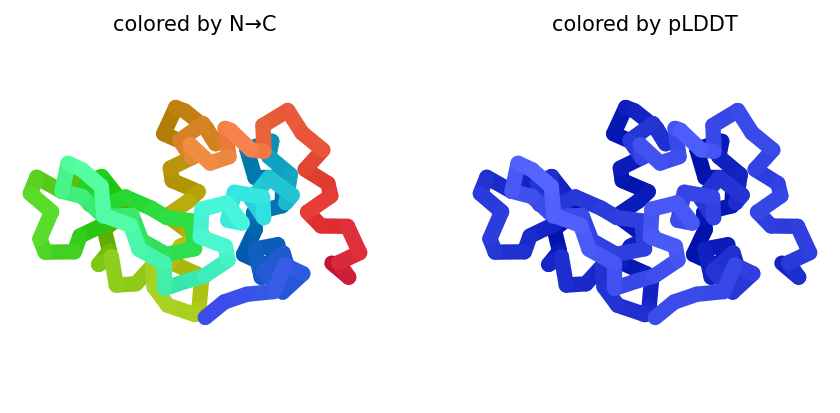

2026-01-27 16:09:30 INFO reranking models by 'plddt' metric
2026-01-27 16:09:30 INFO rank_001_alphafold2_ptm_model_5_seed_000 pLDDT=98.1 pTM=0.91
2026-01-27 16:09:30 INFO rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=97.8 pTM=0.902
2026-01-27 16:09:30 INFO rank_003_alphafold2_ptm_model_3_seed_000 pLDDT=97.8 pTM=0.9
2026-01-27 16:09:30 INFO rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=97.6 pTM=0.9
2026-01-27 16:09:30 INFO rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=97.4 pTM=0.894
2026-01-27 16:09:31 INFO Done
 已完成预测并打包：Lysozyme_ce6c6.result.zip


In [8]:
#@title 运行预测（Run Prediction）
display_images = True #@param {type:"boolean"}
#@markdown - 是否在运行过程中显示图像（例如 MSA 可视化、预测结构示意图）。关闭可以更省显存/更快一些。

import sys
import warnings

# 屏蔽一些不影响结果的警告信息
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np

# --- GPU 检测：如果是 Tesla K80，会有限制（课堂提示用） ---
# K80 显存与性能较弱，长序列/复合物更容易 OOM 或失败
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass

if "1" in K80_chk:
  print(" 警告：检测到 GPU 为 Tesla K80，建议总长度 < 1000（否则可能很慢或直接失败）")
  # 清理可能导致内存策略异常的环境变量（保持与原 notebook 行为一致）
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
import matplotlib.pyplot as plt

# --- Amber relax 相关：为了让 pdbfixer 能被正确 import，需要把 site-packages 加入 sys.path ---
#（这段属于“环境兼容性补丁”，尽量不要改）
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
  sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

# ========== 回调函数（用于可视化/展示） ==========
# input_features_callback：拿到输入特征后，绘制 MSA
def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

# prediction_callback：每个模型预测完成后，可视化结构（未 relax 的结构）
def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

# ========== 日志与任务目录 ==========
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))
import os, time, logging
os.environ["TZ"] = "Asia/Shanghai"
time.tzset()

for h in logging.getLogger().handlers:
    h.setFormatter(logging.Formatter(
        fmt="%(asctime)s %(levelname)s %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    ))
#@markdown - 运行日志将保存在 `jobname/log.txt`，便于课堂复盘与排错。

# ========== 读取输入（queries）并自动判断单体/复合物 ==========
queries, is_complex = get_queries(queries_path)
#@markdown - `queries_path` 来自前面生成的 CSV（或自定义 MSA 时的 a3m）。
#@markdown - `is_complex=True` 通常表示输入含有 `:` 分链（多链复合物）。

# 自动决定最终模型类型（如果你在高级设置里选了 auto，这里会按输入类型调整）
model_type = set_model_type(is_complex, model_type)

# ========== 关于 use_cluster_profile 的说明 ==========
# multimer + 限制 max_msa 时，关闭 cluster profile 更合适（保持原 notebook 逻辑）
if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

# ========== 下载 AlphaFold 参数（只下载与你选择的 model_type 对应的参数） ==========
# （第一次运行会比较久；后续会复用缓存）
download_alphafold_params(model_type, Path("."))

# ========== 正式运行预测 ==========
# 这里的参数非常多：建议课堂上主要讲“哪些是你会改的”（如 msa_mode、pair_mode、model_type、num_recycles、dropout、max_msa）
# 其它参数尽量保持默认，以保证复现稳定性。
results = run(
  queries=queries,
  result_dir=result_dir,
  use_templates=use_templates,
  custom_template_path=custom_template_path,
  num_relax=num_relax,
  msa_mode=msa_mode,
  model_type=model_type,

  # 常见默认：一般跑 5 个模型（model_1 ~ model_5）
  num_models=5,

  num_recycles=num_recycles,
  relax_max_iterations=relax_max_iterations,
  recycle_early_stop_tolerance=recycle_early_stop_tolerance,

  # 采样相关：seeds + dropout + max_msa
  num_seeds=num_seeds,
  use_dropout=use_dropout,

  model_order=[1,2,3,4,5],
  is_complex=is_complex,
  data_dir=Path("."),

  # keep_existing_results=False：每次重新跑，覆盖旧结果
  keep_existing_results=False,

  # rank_by="auto"：自动选择评分来排序候选结构
  rank_by="auto",

  pair_mode=pair_mode,
  pairing_strategy=pairing_strategy,

  # stop_at_score：达到某个阈值就提前停止（这里设得很高，相当于“基本不停”）
  stop_at_score=float(100),

  # 预测过程可视化回调（可关 display_images 来跳过）
  prediction_callback=prediction_callback,

  dpi=dpi,

  # 是否压缩结果：此处 zip_results=False，后面我们用系统 zip 命令手动压缩
  zip_results=False,

  # 保存相关
  save_all=save_all,
  save_recycles=save_recycles,

  # MSA 深度控制与 cluster profile
  max_msa=max_msa,
  use_cluster_profile=use_cluster_profile,

  # 输入特征回调（MSA 图）
  input_features_callback=input_features_callback,

  # 用户标识（不影响结果）
  user_agent="colabfold/google-colab-main",

  # 额外评分
  calc_extra_ptm=calc_extra_ptm,
)

# ========== 打包结果 ==========
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")
print(f" 已完成预测并打包：{results_zip}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

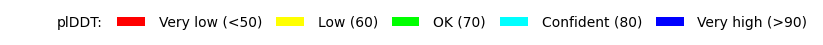

In [13]:
#@title 3D 结构可视化（Display 3D structure） {run: "auto"}

import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list

#@markdown **选择要展示的 Top 排名结构：**
#@markdown - `rank_num=1`：显示评分最高（rank_1）的结构
#@markdown - `rank_num=5`：显示第 5 名结构（rank_5）
rank_num = 5 #@param ["1", "2", "3", "4", "5"] {type:"raw"}

#@markdown **着色方式（color）：**
#@markdown - `lDDT`：按置信度（pLDDT）着色（最常用）
#@markdown - `chain`：按链着色（复合物/多链时最清晰）
#@markdown - `rainbow`：彩虹色谱（按序列位置变化）
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]

#@markdown **pLDDT 颜色含义（课堂速记）：**
#@markdown - **pLDDT < 50**：通常不可靠（可能是无序区/柔性区域/模型不确定）
#@markdown - **50–70**：低到一般（可参考，但不要过度解读细节）
#@markdown - **70–90**：较可信（常用于结构域整体判断）
#@markdown - **> 90**：非常可信（局部结构往往很稳定）
#@markdown *提示：pLDDT 是“局部置信度”，高 pLDDT 不等于整体构象一定正确；复合物界面还需要结合 ipTM/PAE 等指标综合判断。*

#@markdown **是否显示侧链（sidechains）：**
#@markdown - 开启后会显示更多原子（更细节），但可能更卡、更乱（课堂演示建议先关）
show_sidechains = False #@param {type:"boolean"}

#@markdown **是否显示主链（mainchains）：**
#@markdown - 开启后会以 stick 方式显示主链原子（更细节），也会更耗渲染
show_mainchains = False #@param {type:"boolean"}

# -----------------------------
# 选定要展示的模型文件（PDB）
# -----------------------------
tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  """
  用 py3Dmol 显示 PDB 结构。
  参数：
  - rank_num：显示第几名（1~5）
  - show_sidechains：是否显示侧链（更细节但更拥挤）
  - show_mainchains：是否以 stick 形式显示主链原子
  - color：着色方式（lDDT / chain / rainbow）
  """
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0], 'r').read(), 'pdb')

  # 按 pLDDT（存储在 PDB 的 B-factor 字段 b）做渐变着色
  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color': 'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n, chain, c in zip(range(chains), alphabet_list, pymol_color_list):
      view.setStyle({'chain': chain}, {'cartoon': {'color': c}})

  if show_sidechains:
    BB = ['C', 'O', 'N']
    view.addStyle({'and': [{'resn': ["GLY", "PRO"], 'invert': True}, {'atom': BB, 'invert': True}]},
                  {'stick': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})
    view.addStyle({'and': [{'resn': "GLY"}, {'atom': 'CA'}]},
                  {'sphere': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})
    view.addStyle({'and': [{'resn': "PRO"}, {'atom': ['C', 'O'], 'invert': True}]},
                  {'stick': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})

  if show_mainchains:
    BB = ['C', 'O', 'N', 'CA']
    view.addStyle({'atom': BB}, {'stick': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()

# 如果按 lDDT 着色，则额外显示 pLDDT 图例（帮助学生理解颜色含义）
if color == "lDDT":
  plot_plddt_legend().show()


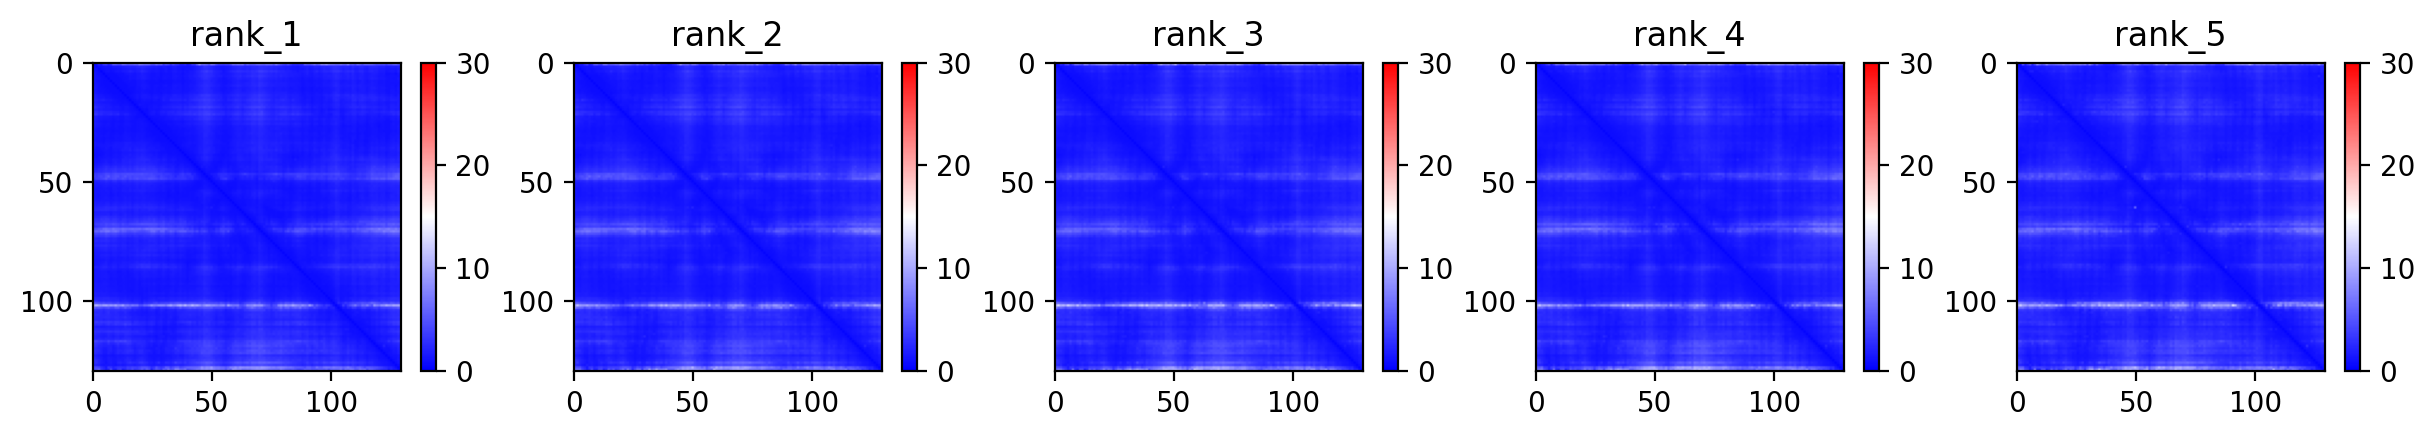
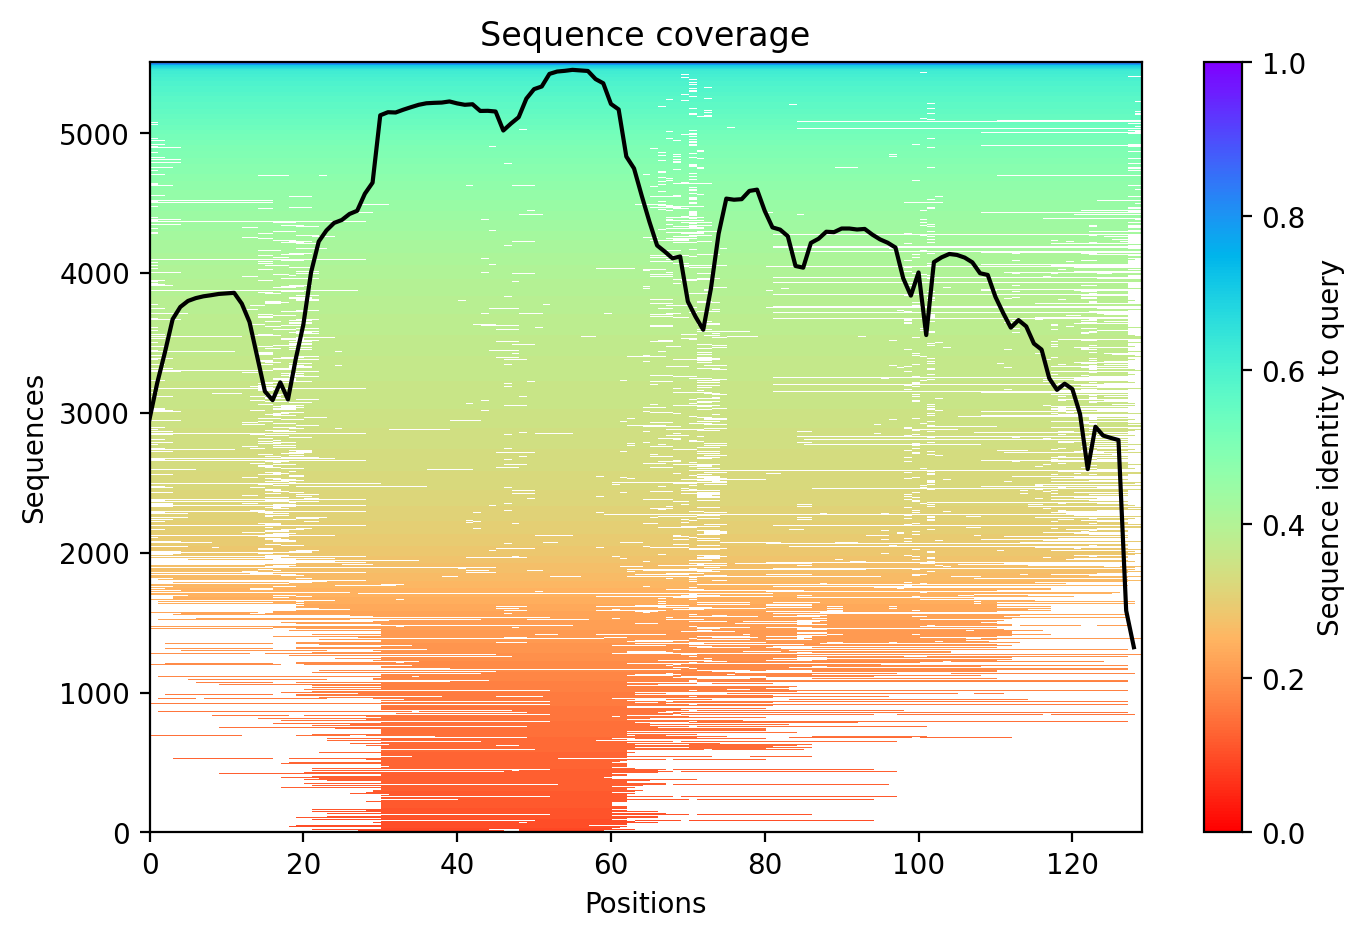
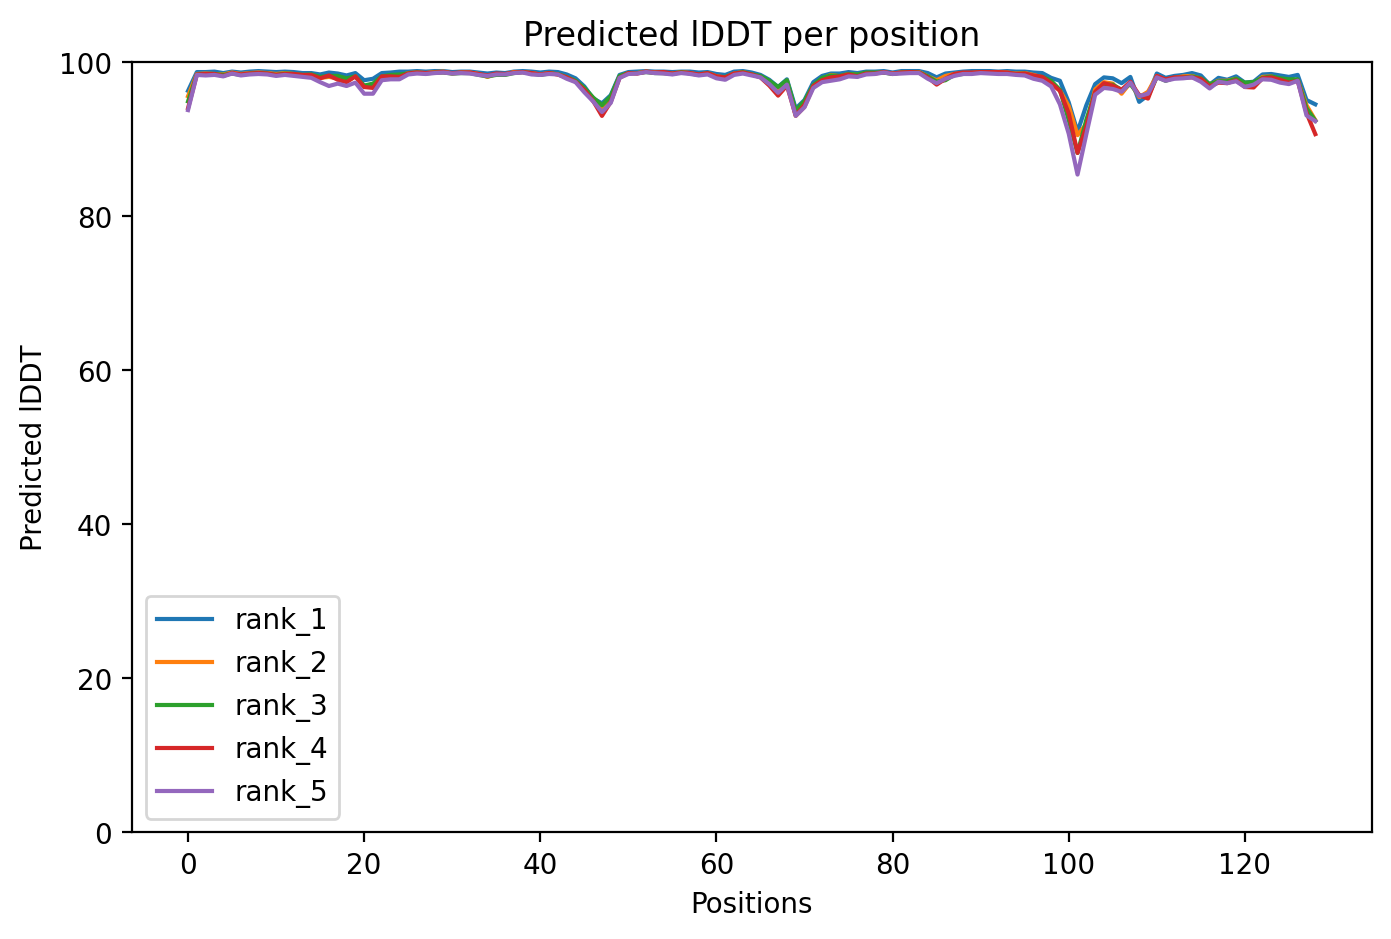

In [14]:
#@title 图表汇总（Plots） {run: "auto"}
#@markdown 这里将对实验图表进行汇总并解读。
from IPython.display import display, HTML
import base64
from html import escape
import os

# 把图片文件转换成可直接嵌入网页的 data URL（base64）
# 参考：https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f"data:image/{ext};base64,"
  with open(filename, "rb") as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode("utf-8")

# -----------------------------
# 读取图像文件（如果存在）
# -----------------------------
pae = ""
pae_file = os.path.join(jobname, f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
  pae = image_to_data_url(pae_file)

cov = image_to_data_url(os.path.join(jobname, f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname, f"{jobname}{jobname_prefix}_plddt.png"))

# -----------------------------
# 显示
# -----------------------------
display(HTML(f"""
<style>
  img {{
    border-radius: 10px;
    margin: 0.6em 0.8em 0.6em 0;
    display: block;
  }}
  img.half {{ float:left; max-width:50%; }}
  img.full {{ float:none; max-width:100%; width:100%; }}

  @media (max-width:640px) {{
    img.half {{
      float:none;
      max-width:100%;
      width:100%;
    }}
  }}

  .card {{
    background: #fafafa;
    border: 1px solid #e6e6e6;
    border-radius: 14px;
    padding: 1.2em 1.3em;
    margin: 0.8em 0;
    box-shadow: 0 1px 2px rgba(0,0,0,0.04);
  }}
  .note {{
    color: #333;
    line-height: 1.65;
    font-size: 0.98em;
  }}
  .small {{
    color: #555;
    font-size: 0.92em;
  }}
  code {{
    background: #f1f1f1;
    padding: 0.1em 0.35em;
    border-radius: 6px;
  }}
  ul {{
    margin: 0.4em 0 0.2em 1.2em;
  }}
</style>

<div style="max-width:92%; padding:2em;">

  <h1>图表（Plots）：{escape(jobname)}</h1>

  <div class="card note">
    <b> 解读：</b>
    <ul>
      <li><b>pLDDT（置信度）</b>：看每个残基“局部结构”是否可靠。一般 <b>&gt;90</b> 很高，<b>70–90</b> 较好，<b>50–70</b> 一般，<b>&lt;50</b> 往往不可靠（可能是柔性/无序区）。</li>
      <li><b>Coverage（覆盖度）</b>：看 MSA 有多“深”（支持信息是否充足）。覆盖越好、越均匀，通常越有利于预测稳定。</li>
      <li><b>PAE（Predicted Aligned Error）</b>：看“两个残基/两个结构域之间的相对位置是否可靠”。<br/>
          <span class="small">（单体时常用于判断结构域之间相对摆放是否可信；复合物时常用于判断链间相对位置/界面是否稳定。）</span>
      </li>
    </ul>
    <div class="small">
      <b>常见误区：</b>高 pLDDT ≠ 整体构象一定正确；复合物是否靠谱还要结合 <code>PAE</code>、（如果你开启了）链间评分如 ipTM/actifptm 等综合判断。
    </div>
  </div>

  <div class="card note">
    <b>如何快速读图：</b>
    <ul>
      <li><b>先看 pLDDT 图：</b>哪里低就先别解读细节（例如环区、末端、柔性 linkers）。</li>
      <li><b>再看 Coverage 图：</b>如果某段覆盖很差，往往对应 pLDDT 也会偏低。</li>
      <li><b>最后看 PAE 图（如果有）：</b>结构域之间/链之间如果 PAE 很高，说明相对位置不稳；这时“每个域内部可能对，但域与域之间的摆放不一定对”。</li>
    </ul>
  </div>

  <h2>结果图（自动加载）</h2>
  <div class="small">
    说明：如果本次运行没有生成 PAE 图（例如某些设置/任务类型），页面会自动隐藏 PAE。
  </div>

  { '<!--' if pae == '' else '' }
    <h3>PAE 图（Predicted Aligned Error，预测对齐误差）</h3>
    <img src="{pae}" class="full" />
    <div style="clear:both;"></div>
  { '-->' if pae == '' else '' }

  <h3>Coverage 图（MSA 覆盖度）</h3>
  <img src="{cov}" class="half" />
  <div style="clear:both;"></div>

  <h3>pLDDT 图（按残基置信度）</h3>
  <img src="{plddt}" class="half" />
  <div style="clear:both;"></div>

</div>
"""))

In [15]:
#@title 打包并下载结果（Package and download results）
#@markdown **下载提示（如果下载失败）：**
#@markdown 1) 如果你装了广告拦截器（AdBlock），请先临时关闭，然后重新运行本单元格。
#@markdown 2) 仍然失败的话：点击左侧“文件”面板（小文件夹图标），找到文件：`jobname.result.zip`，
#@markdown    右键选择 **Download（下载）**。
#@markdown    参考截图（外链）：https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small
#@markdown **课堂建议：**下载的是本次任务的所有输出（结构、评分、图表、日志等），便于课后复盘或提交作业。

# 如果使用了自定义 MSA，提醒学生/读者：论文或报告中需要引用自己生成 MSA 的方法
if msa_mode == "custom":
  print(" 提醒：你使用了自定义 MSA（custom MSA）。写报告/论文时别忘了引用你生成该 MSA 的方法与工具。")

# 下载压缩包
files.download(f"{jobname}.result.zip")
print(f" 已生成压缩包：{jobname}.result.zip")

# 如果开启了保存到 Google Drive，则同时上传一份到 Drive（便于长期保存和分享）
if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f" 已上传到 Google Drive：{jobname}.result.zip（文件 ID：{uploaded.get('id')}）")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 已生成压缩包：Lysozyme_ce6c6.result.zip


# 使用说明（Instructions）  <a name="Instructions"></a>

本版本为中文版本，如需查看英文原版，请点击链接：[v1.5.5](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)。

如需更详细的说明、技巧与注意事项，请参考近期发表在 **Nature Protocols** 的文章：  
[Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)。

---

## 快速开始（Quick start）

1. 将你的蛋白质序列（单条或多条）粘贴到输入框中。  
2. 点击 **“运行时(Runtime)” → “全部运行(Run all)”**。  
3. 整个流程（pipeline）包含 **5 个步骤**。当前正在运行的步骤，会在左侧以**带停止标志的圆形图标**进行提示。

---

## 结果压缩包内容（Result zip file contents）

压缩包通常包含：

1. **PDB 格式结构文件**：按平均 **pLDDT** 排序；复合物按 **pTMscore** 排序。（若启用 `use_amber`，会同时提供 **unrelaxed（未松弛）** 和 **relaxed（松弛后）** 的结构。）  
2. **模型质量图（model quality plots）**。  
3. **MSA 覆盖度图（MSA coverage plots）**。  
4. **参数日志文件（parameter log file）**。  
5. **A3M 格式的输入 MSA 文件**。  
6. 一个使用 [AlphaFold-DB 格式](https://alphafold.ebi.ac.uk/faq#faq-7) 的 `predicted_aligned_error_v1.json`，以及每个模型对应的 `scores.json`：  
   - `scores.json` 包含：  
     - PAE 的数组（列表的列表，list of lists），  
     - 平均 pLDDT（average pLDDT）的列表，  
     - pTMscore。  
7. 一个 **BibTeX 引用文件**：包含本次使用到的所有工具与数据库的引用信息。

任务结束时，浏览器会弹出下载窗口，提供 `jobname.result.zip` 文件。  
另外，如果勾选了 `save_to_google_drive` 选项，`jobname.result.zip` 也会上传到你的 Google Drive。

---

## 复合物的 MSA 生成（MSA generation for complexes）

复合物预测会使用 **unpaired MSA（不配对 MSA）** 与 **paired MSA（配对 MSA）**：

- **Unpaired MSA（不配对）**：生成方式与单体预测类似，通过搜索 **UniRef100** 与环境序列（environmental sequences），各进行三轮迭代搜索。  
- **Paired MSA（配对）**：  
  - 在 **UniRef100** 中搜索；  
  - 将具有相同 **NCBI 分类标识（taxonomic identifier，即物种或亚种）** 的最佳命中进行配对；  
  - 只有当该分类标识下 **所有查询链都能找到对应序列** 时，才进行配对（保证配对一致性）。

---

## 使用自定义 MSA 作为输入（Using a custom MSA as input）

若要使用自定义 MSA（A3M 格式）进行结构预测：  
1) 将 `msa_mode` 改为 `"custom"`；  
2) 在 “MSA options …” 区域末尾等待上传框出现；  
3) 上传你的 A3M 文件。  

**重要要求：**A3M 的第一条 FASTA 记录必须是**无 gap（不含“-”）的查询序列**。

也可以为复合物预测提供自定义 MSA。格式说明见：  
[格式说明（issue #76）](https://github.com/sokrypton/ColabFold/issues/76)

如果你想用另一种方式生成 MSA，也可以使用 [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits)：  
提交序列后，点击 **“Query Template MSA” → “Download Full A3M”**，下载 A3M 再上传到本 notebook。

---

## PDB100 <a name="pdb100"></a>

截至 **2023-06-08（23/06/08）**，我们已从 **PDB70** 切换到 **PDB100（100% 聚类的 PDB）**。PDB100 的构建方法与 PDB70 不同。

- **PDB70**：将每个 PDB70 代表序列用 [HHblits](https://github.com/soedinglab/hh-suite) 在 [Uniclust30](https://uniclust.mmseqs.com/) 上搜索构建。  
- **PDB100**：将每个 PDB100 代表结构用 [Foldseek](https://github.com/steineggerlab/foldseek) 在 [AlphaFold Database](https://alphafold.ebi.ac.uk) 上搜索构建。  

为了兼容旧版 notebook 和本地安装，生成文件与 API 返回内容仍可能继续使用 “PDB70” 命名，即使实际使用的是 PDB100。

---

## 使用自定义模板（Using custom templates） <a name="custom_templates"></a>

若要使用自定义模板（PDB 或 mmCIF 格式）进行预测：  
1) 在执行单元格中将 `template_mode` 改为 `"custom"`；  
2) 在 “Input Protein” 区域末尾等待上传框出现；  
3) 选择并上传模板文件（支持多选）。

注意事项：  
- 模板文件名必须符合 **4 个字母的 PDB 命名规则**，并使用**小写字母**。  
- mmCIF 模板必须包含 `_entity_poly_seq` 字段，否则会报错。若缺少 `_pdbx_audit_revision_history.revision_date` 字段，会自动生成。  
- PDB 模板会自动转换为 mmCIF，并自动生成 `_entity_poly_seq` 与 `_pdbx_audit_revision_history.revision_date`（如果缺失）。

如遇问题请反馈：  
[issue #177](https://github.com/sokrypton/ColabFold/issues/177)

---

## 与完整 AlphaFold2 / AlphaFold2 Colab 的对比（Comparison to the full AlphaFold2 and AlphaFold2 Colab）

本 notebook 使用 **MMseqs2** 替代了 AlphaFold2 的同源检测与 MSA 配对流程。  
如需与 [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) 和完整 [AlphaFold2](https://github.com/deepmind/alphafold) 系统对比，请阅读论文：  
[paper](https://www.nature.com/articles/s41592-022-01488-1)

---

## 故障排查（Troubleshooting）

- 确认运行时类型为 GPU：**“运行时(Runtime)” → “更改运行时类型(Change runtime type)”**。  
- 尝试重置环境：**“运行时(Runtime)” → “恢复出厂设置(Factory reset runtime)”**。  
- 检查输入序列是否正确。

---

## 已知问题（Known issues）

- Google Colab 会分配不同型号 GPU，显存不一；部分 GPU 可能无法处理很长序列。  
- 浏览器可能阻止下载弹窗：可改用 `save_to_google_drive` 上传到 Drive，或手动下载：  
  点击左侧文件夹图标 → 找到 `jobname.result.zip` → 右键选择 **Download**（参考截图：  
  [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)）。

---

## 局限性（Limitations）

- **计算资源**：MMseqs2 API 每天可处理约 **20k–50k** 请求。  
- **MSA 命中数量**：MMseqs2 很精准且敏感，但相比 HHblits/HMMer 在 BFD 或 MGnify 上搜索，可能找到更少的 hits。  
- 建议在需要更严谨结论时，额外使用完整 [AlphaFold2 pipeline](https://github.com/deepmind/alphafold)。

---

## 图表说明（Description of the plots）

- **每个位点的序列数量（Number of sequences per position）**：  
  希望每个位点至少 ~30 条序列，理想情况 ~100 条序列。  
- **每个位点的预测 lDDT（Predicted lDDT per position）**：  
  每个位置的模型置信度（满分 100），越高越好。  
- **预测对齐误差（Predicted Alignment Error / PAE）**：  
  对同源寡聚体（homooligomers）而言，可用于评估界面置信度，越低越好。

---

## Bug 反馈（Bugs）

如遇 bug，请到这里反馈：  
https://github.com/sokrypton/ColabFold/issues

---

## 许可证（License）

ColabFold 源码采用 [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE) 许可。  
本 notebook 同时使用 AlphaFold2 源码与参数：  
- 源码许可：[Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE)  
- 参数许可：[CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/)  

更多 AlphaFold 许可说明见：  
https://github.com/deepmind/alphafold/main/LICENSE

---
